# 1.Instalacion y/o importacion de librerias

In [1]:
pip install fitter

     |████████████████████████████████| 47 kB 3.8 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25025 sha256=91bc9e51c61c211022046f0d9f1ad7665e4d51725ae3a4b93f373acf5fe538df
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=1fc53b6eab56a4a815a7593bc697281b39cd20091d3c4186602196a617050f17
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


In [2]:
pip install holidays_co

In [3]:
import datetime
import holidays_co

In [4]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, RepeatVector, TimeDistributed, LSTM
from tensorflow import keras
from keras.layers import Dense,Activation,Flatten

In [5]:
import pandas as pd
from pandas import concat
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from tqdm import tqdm
sns.set()
import calendar
%matplotlib inline
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import MinMaxScaler

#Modelos
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error , make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


# SPLIT DE LOS DATOS 
from sklearn.model_selection import train_test_split

import multiprocessing


from fitter import Fitter, get_common_distributions

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

from statsmodels.graphics.tsaplots import plot_pacf

# 2.Funciones se utilizaran en el proyecto

Funcion para evaluar error medio adsoluto en datos de test y de traind

In [6]:
def evaluate_model(*, model, metric, X_train, y_train, X_test, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    train_error = metric(y_train, train_predictions)
    test_error = metric(y_test, test_predictions)
    return {
        "train_predictions": train_predictions,
        "test_predictions": test_predictions,
        "train_error": train_error,
        "test_error": test_error
    }

def print_report(*, model, evaluation):
    print(f"Model used:\n\t{model}")
    print(f"Error:\n\ttrain set MAE: {evaluation['train_error']}\n\ttest error MAE: {evaluation['test_error']}")

Funcion para evaluar el error en porcentaje

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_array(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Funcion para filtrar por  terminales

In [8]:
def filtro_terminal_origen(data, origen):
  Filtro_tt_origen=data.where(data['TERMINAL']==origen)
  Eliminar_NaN=Filtro_tt_origen.dropna()
  data=Eliminar_NaN.reset_index() # Se filta por terminal del Norte
  return data

Funcion para convertir Dataset a supervisado 

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# 3.Lectura de la data original

In [10]:
url= 'https://raw.githubusercontent.com/MarcusBruDiaz/Monografia/main/Dataset_pasajeros_TT_norte_Medellin_limpio.csv'
Data= pd.read_csv(url)

In [11]:
Data.head()

,FECHA_DESPACHO,TERMINAL,CLASE_VEHICULO,NIVEL_SERVICIO,MUNICIPIO_ORIGEN_RUTA,MUNICIPIO_DESTINO_RUTA,HORA_DESPACHO,TIPO_DESPACHO,DESPACHOS,PASAJEROS
0,2021-01-28,T.T. DE MEDELLÍN NORTE,MICROBUS,BASICO,5001.0,5264.0,5.0,ORIGEN,1.0,3.0
1,2021-02-09,T.T. DE MEDELLÍN NORTE,BUS,BASICO,5001.0,5858.0,16.0,ORIGEN,1.0,8.0
2,2021-02-10,T.T. DE MEDELLÍN NORTE,BUS,BASICO,5001.0,5440.0,8.0,ORIGEN,5.0,32.0
3,2021-02-17,T.T. DE MEDELLÍN NORTE,BUS,BASICO,5001.0,5756.0,16.0,ORIGEN,1.0,1.0
4,2021-01-30,T.T. DE MEDELLÍN NORTE,BUS,BASICO,5001.0,5490.0,10.0,ORIGEN,1.0,27.0


In [12]:
# se eliminan columas que para nuestro proyecto evidentemente no desceriben nada la variable objetivo
Data=Data.drop(["TERMINAL","CLASE_VEHICULO","NIVEL_SERVICIO","MUNICIPIO_ORIGEN_RUTA","MUNICIPIO_DESTINO_RUTA","HORA_DESPACHO","TIPO_DESPACHO"], axis=1)

In [13]:
Data

,FECHA_DESPACHO,DESPACHOS,PASAJEROS
0,2021-01-28,1.0,3.0
1,2021-02-09,1.0,8.0
2,2021-02-10,5.0,32.0
3,2021-02-17,1.0,1.0
4,2021-01-30,1.0,27.0
...,...,...,...
620047,2021-09-27,3.0,100.0
620048,2021-09-03,2.0,58.0
620049,2021-09-08,4.0,29.0
620050,2021-09-15,1.0,24.0


# 4.Exploracion de los datos

Tipos de variables

In [14]:
Data.dtypes

FECHA_DESPACHO     object
DESPACHOS         float64
PASAJEROS         float64
dtype: object

Se revisa el tamaño del dataset con el que se inicia para la investigacion , esta conformado por 792 filas y 2 columnas

In [15]:
Data.shape

(620052, 3)

Se revisa los registris vacios , dando colo resultado que no existen registros vacios

In [16]:
# SE REVISAN LOS DATOS VACIOS
Data.isnull().sum()

FECHA_DESPACHO    0
DESPACHOS         0
PASAJEROS         0
dtype: int64

In [17]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620052 entries, 0 to 620051
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   FECHA_DESPACHO  620052 non-null  object 
 1   DESPACHOS       620052 non-null  float64
 2   PASAJEROS       620052 non-null  float64
dtypes: float64(2), object(1)
memory usage: 14.2+ MB


# 5.Preprocesamiento de los datos

## 5.1 Se camia el formaro de la columna "FECHA_DESPACHO"

 Se decide cambiar el tipo de detos de la columna FECHA_DESPACHO , para tener mejor manejo de esta variable

In [18]:
# Se cambia tipo de formato columna "FECHA_DESPACHO"
Data["FECHA_DESPACHO"]= pd.to_datetime(Data["FECHA_DESPACHO"])

## 5.2 Establecer fecha como indice

Se establece coomo indice la columna fecha

In [19]:
#se establece como indice la columna fecha
Data = Data.set_index('FECHA_DESPACHO')

In [20]:
Data

,DESPACHOS,PASAJEROS
FECHA_DESPACHO,,
2021-01-28,1.0,3.0
2021-02-09,1.0,8.0
2021-02-10,5.0,32.0
2021-02-17,1.0,1.0
2021-01-30,1.0,27.0
...,...,...
2021-09-27,3.0,100.0
2021-09-03,2.0,58.0
2021-09-08,4.0,29.0


## 5.3 Se agrupan fechas por frecuencia diaria

In [21]:
# se agrupan por dias los registros y se suman las variables numerias
Data=Data.resample('D').sum()

In [22]:
Data

,DESPACHOS,PASAJEROS
FECHA_DESPACHO,,
2019-08-01,1986.0,24116.0
2019-08-02,2133.0,28542.0
2019-08-03,2218.0,32093.0
2019-08-04,1900.0,28381.0
2019-08-05,2084.0,28555.0
...,...,...
2021-09-26,1557.0,19800.0
2021-09-27,1797.0,20965.0
2021-09-28,1718.0,17965.0


## 5.5 Se cammbia el tipo de variable DESPACHOS Y PASAJEROS de float64 a int 

In [23]:
 Data['PASAJEROS']=pd.to_numeric(Data['PASAJEROS'], downcast='integer')

In [24]:
 Data['DESPACHOS']=pd.to_numeric(Data['DESPACHOS'], downcast='integer')

In [25]:
Data.head()

,DESPACHOS,PASAJEROS
FECHA_DESPACHO,,
2019-08-01,1986,24116
2019-08-02,2133,28542
2019-08-03,2218,32093
2019-08-04,1900,28381
2019-08-05,2084,28555


In [26]:
Data.dtypes

DESPACHOS    int16
PASAJEROS    int32
dtype: object

# 6.Analisis descriptivo

In [27]:
Data.describe()

,DESPACHOS,PASAJEROS
count,792.000000,792.000000
mean,1465.151515,16054.343434
std,650.435540,10051.400196
min,15.000000,52.000000
25%,1253.000000,9089.750000
50%,1677.500000,15903.500000
75%,1944.000000,23171.250000
max,2696.000000,52447.000000


Se revisa la distribucion de la variable "PASAJEROS"

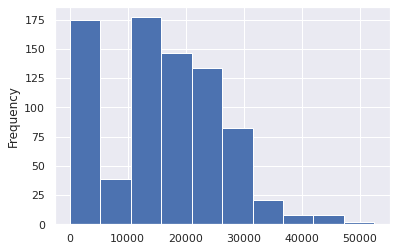

In [28]:
Data['PASAJEROS'].plot.hist(bins=10)

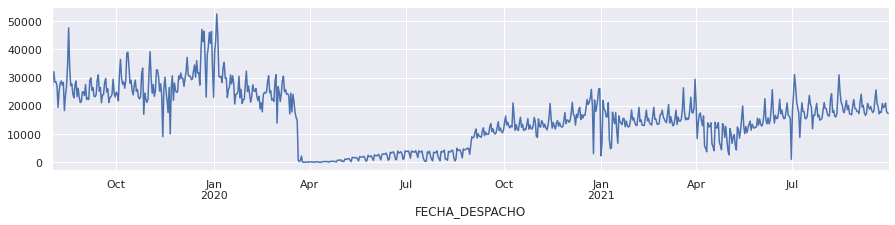

In [29]:
Data["PASAJEROS"].plot(figsize=(15,3))

Se revisa la distribucion de la variable "DESPACHOS"

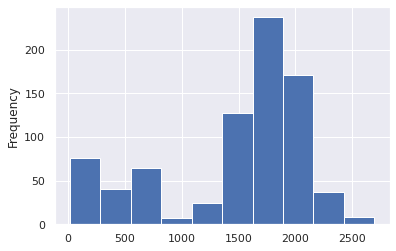

In [30]:
Data['DESPACHOS'].plot.hist(bins=10)

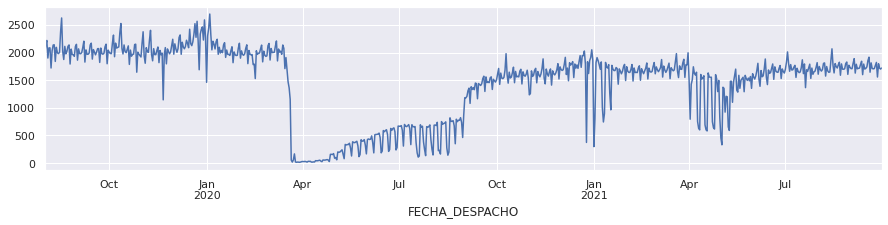

In [31]:
Data["DESPACHOS"].plot(figsize=(15,3))

Se muestra en una tabla el promedio de despachos y pasajeros por mes

In [33]:
meses =Data.resample('M').mean()
meses

,DESPACHOS,PASAJEROS
FECHA_DESPACHO,,
2019-08-31,2050.161290,26857.709677
2019-09-30,2009.166667,25258.300000
2019-10-31,2049.967742,27272.258065
2019-11-30,2006.100000,26083.266667
2019-12-31,2211.096774,34553.741935
2020-01-31,2073.387097,29302.645161
2020-02-29,1971.517241,24690.586207
2020-03-31,1229.580645,14568.451613
2020-04-30,53.866667,312.233333


Se crea un diagranma de dispercion , viendo que existe una correlacion positiva entre la variable "DESPACHOS y la variable "PASAJEROS"

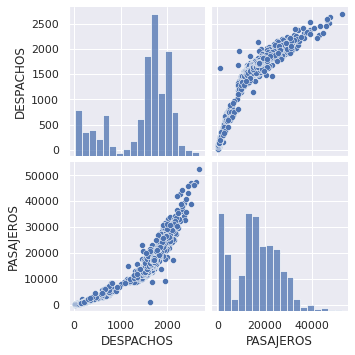

In [34]:
cols = ['DESPACHOS', 'PASAJEROS']
sns.set()
sns.pairplot(Data[cols])  # Se crea una nobe de puntos para ver como estan distribuidas las variales con respecto a otras

Se crea un grafico de correlacion para conocer el coeficiente de correlacion entre las dos variables , donde nuevamente se nota una correlacion bastante alta entre las dos varibles

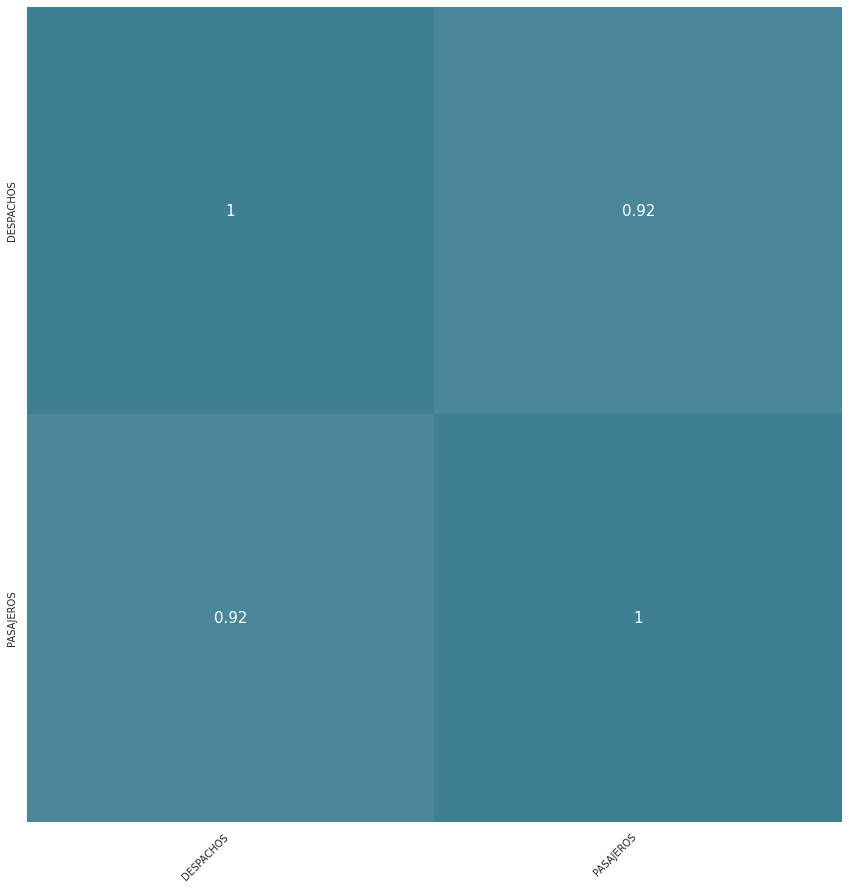

In [35]:
corr_matrix = Data.select_dtypes(include=['int16', 'int32']).corr(method='pearson')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 15},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(30, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

Se analizan nuevamente las distibuciones para la variable "PASAJEROS" pero esta vez analizando con grafico boxplot

[Text(0.5, 0, '')]

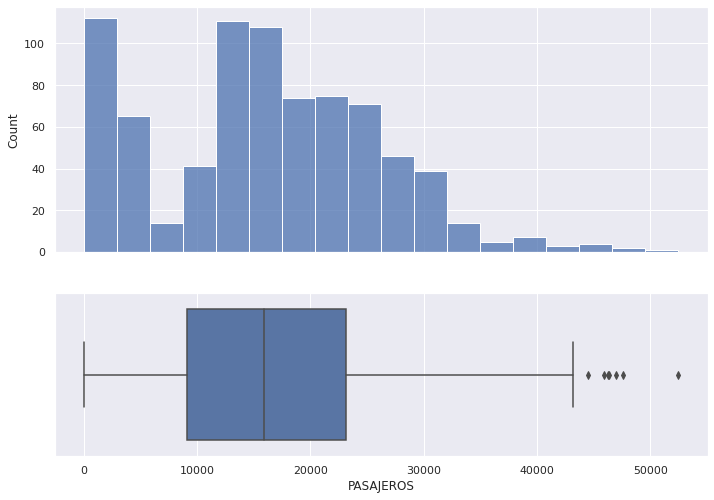

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.6, .4)})
sns.histplot(Data['PASAJEROS'], ax=ax_hist)
sns.boxplot(Data['PASAJEROS'], ax=ax_box)
ax_hist.set(xlabel='')

Se analizan nuevamente las distibuciones para la variable "DESPACHOS" pero esta vez analizando con grafico boxplot

[Text(0.5, 0, '')]

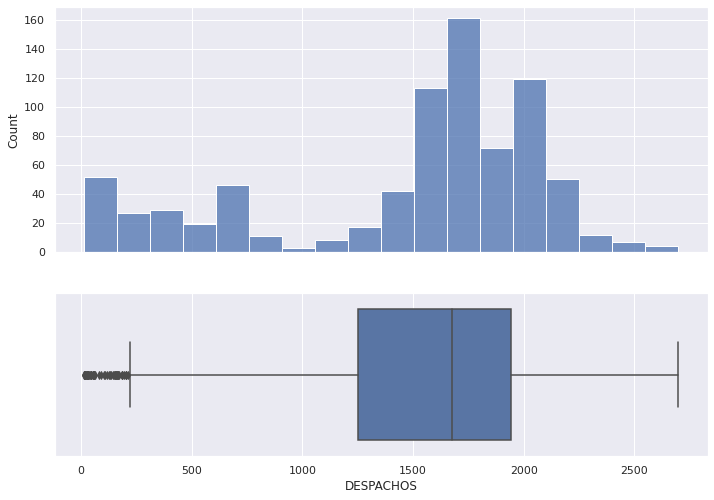

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.6, .4)})
sns.histplot(Data['DESPACHOS'], ax=ax_hist)
sns.boxplot(Data['DESPACHOS'], ax=ax_box)
ax_hist.set(xlabel='')

Coeficiente correlacion parcial 

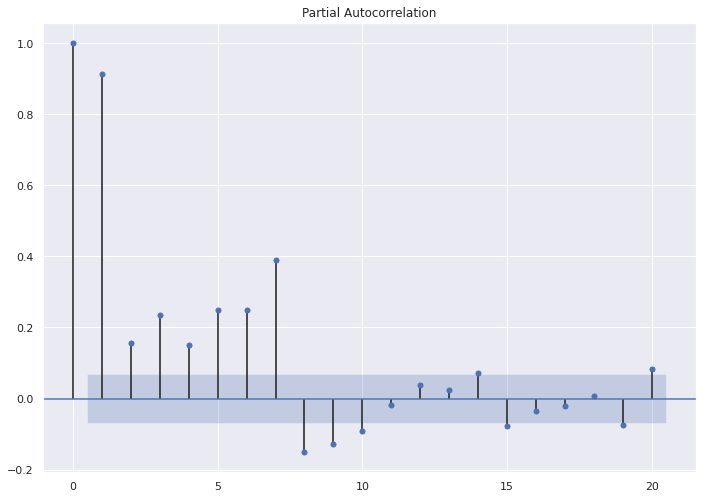

In [38]:
plot_pacf(Data['PASAJEROS'], lags=20)
plt.show()

In [ ]:
#fig, (ax1) = plt.subplots(1,figsize=(20,10), dpi= 70)
#plot_pacf(Data['PASAJEROS'],ax=ax1, lags=50)
#plt.show()

## 6.1 Despues de analizado se decide analizar los datos Post pandemia

In [39]:
Data_post_pandemia=Data["2020-10":]

In [40]:
Data_post_pandemia.describe()

,DESPACHOS,PASAJEROS
count,365.000000,365.000000
mean,1601.526027,15624.909589
std,282.509608,4572.669502
min,298.000000,1125.000000
25%,1555.000000,13057.000000
50%,1666.000000,15506.000000
75%,1741.000000,18197.000000
max,2067.000000,31043.000000


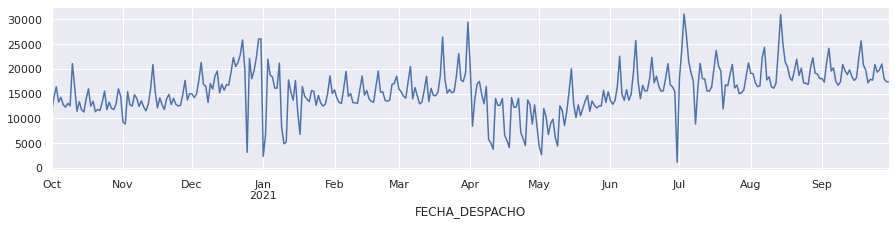

In [41]:
Data_post_pandemia["PASAJEROS"].plot(figsize=(15,3))

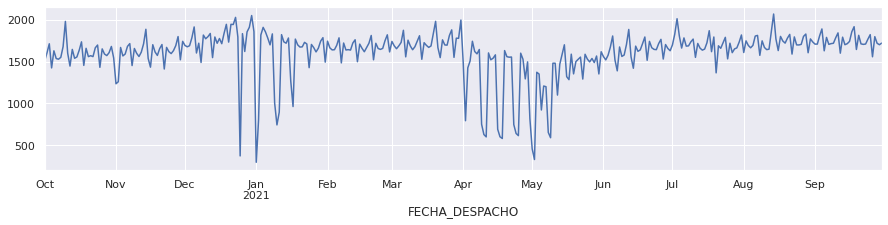

In [42]:
Data_post_pandemia["DESPACHOS"].plot(figsize=(15,3))

[Text(0.5, 0, '')]

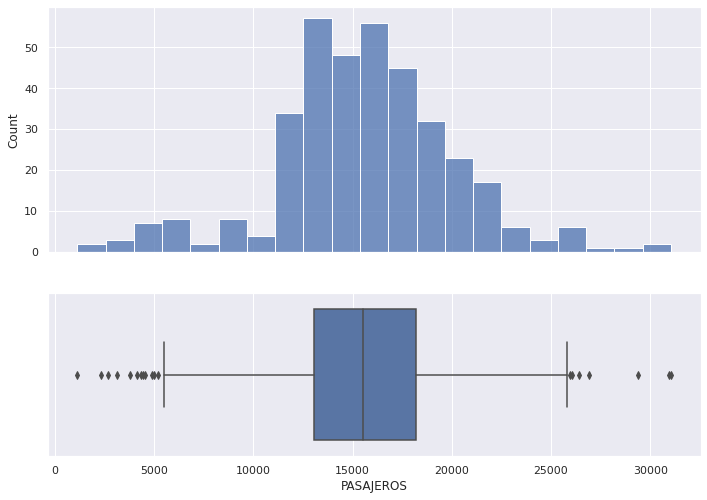

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.6, .4)})
sns.histplot(Data_post_pandemia['PASAJEROS'], ax=ax_hist)
sns.boxplot(Data_post_pandemia['PASAJEROS'], ax=ax_box)
ax_hist.set(xlabel='')

[Text(0.5, 0, '')]

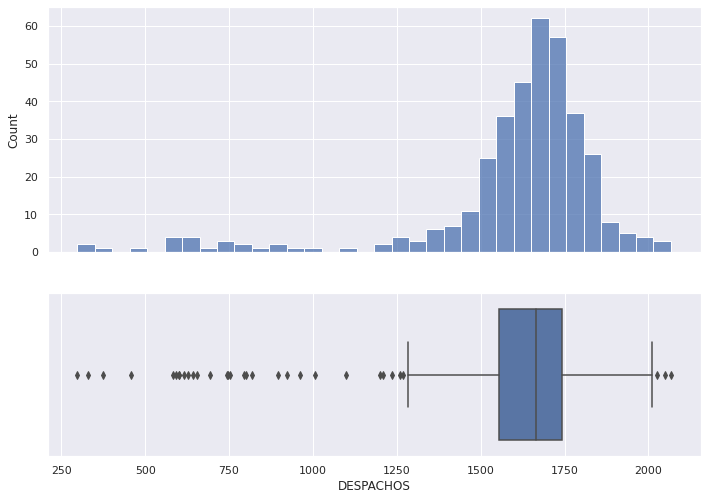

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.6, .4)})
sns.histplot(Data_post_pandemia['DESPACHOS'], ax=ax_hist)
sns.boxplot(Data_post_pandemia['DESPACHOS'], ax=ax_box)
ax_hist.set(xlabel='')

Coeficiente de correlacion parcial Estos gráficos resumen gráficamente la fuerza de la relación entre las observaciones en la serie de tiempo y las observaciones en el paso de tiempo anterior.

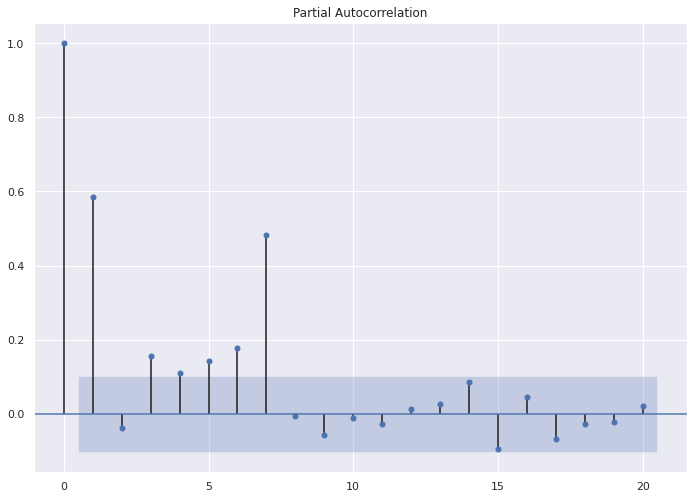

In [45]:
plot_pacf(Data_post_pandemia['PASAJEROS'], lags=20)
plt.show()

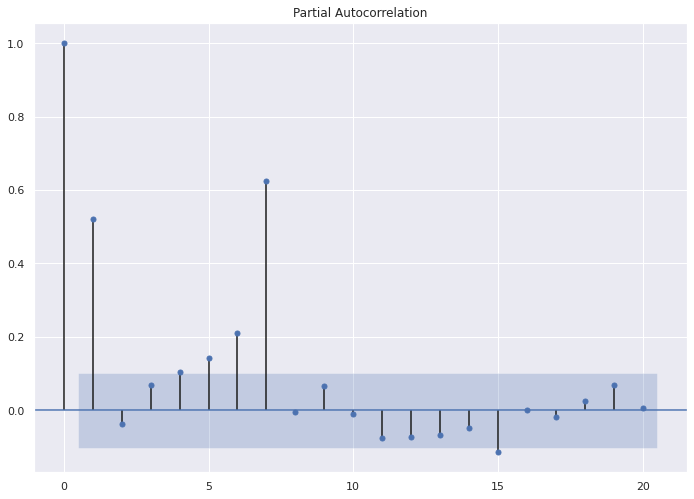

In [46]:
plot_pacf(Data_post_pandemia['DESPACHOS'], lags=20)
plt.show()

# 7.Baseline

## 7.1 Copia dataset original para Baseline

In [139]:
# SE CREA UNA COPIA DEL DATASET
Data_baseline=Data.copy()

In [140]:
Data_baseline.head()

,DESPACHOS,PASAJEROS
FECHA_DESPACHO,,
2019-08-01,1986,24116
2019-08-02,2133,28542
2019-08-03,2218,32093
2019-08-04,1900,28381
2019-08-05,2084,28555


In [141]:
Data_baseline.shape

(792, 2)

## 7.2 Transformar dartos de la series a unos datos para un algoritmo de aprendizaje supervisado

In [142]:
# SE TRANFORMAN LOS DIAS ANTERRIORES EN COLUMNAS , DE TAL MENARA QUE ANALSIZANDO LOS 10 DIAS ANTERIORES DE LAS DOS VARIABLES SE PREDIGA EL DIA 11
step_back = 7
Data_baseline = series_to_supervised(Data_baseline,step_back,1)

In [143]:
Data_baseline

,var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
FECHA_DESPACHO,,,,,,,,,,,,,,,,
2019-08-08,1986.0,24116.0,2133.0,28542.0,2218.0,32093.0,1900.0,28381.0,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033,25252
2019-08-09,2133.0,28542.0,2218.0,32093.0,1900.0,28381.0,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033.0,25252.0,2135,27944
2019-08-10,2218.0,32093.0,1900.0,28381.0,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033.0,25252.0,2135.0,27944.0,2140,28779
2019-08-11,1900.0,28381.0,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033.0,25252.0,2135.0,27944.0,2140.0,28779.0,1839,27358
2019-08-12,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033.0,25252.0,2135.0,27944.0,2140.0,28779.0,1839.0,27358.0,2094,28246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,1644.0,20772.0,1813.0,19736.0,1711.0,17183.0,1705.0,17876.0,1709.0,17697.0,1767.0,20844.0,1821.0,19307.0,1557,19800
2021-09-27,1813.0,19736.0,1711.0,17183.0,1705.0,17876.0,1709.0,17697.0,1767.0,20844.0,1821.0,19307.0,1557.0,19800.0,1797,20965
2021-09-28,1711.0,17183.0,1705.0,17876.0,1709.0,17697.0,1767.0,20844.0,1821.0,19307.0,1557.0,19800.0,1797.0,20965.0,1718,17965


In [144]:
# SE CAMBIA EL NOMBRE DE LA VARIABLE OBJETIVO
Data_baseline=Data_baseline.rename(columns={'var2(t)':'PASAJEROS'})

## 7.3 Division de los datos para entrenar y probar los modelos

In [145]:
# DIVISION DE LOS DATOS
Train, Test = train_test_split(Data_baseline, test_size = 0.20, shuffle = False)

# SE CREAN LOS DATOS DE ENTRENAMIENTO Y TEST 
X_Train = Train.drop(columns='PASAJEROS')
y_Train = Train['PASAJEROS']
X_Test= Test.drop(columns='PASAJEROS')
y_Test= Test['PASAJEROS']

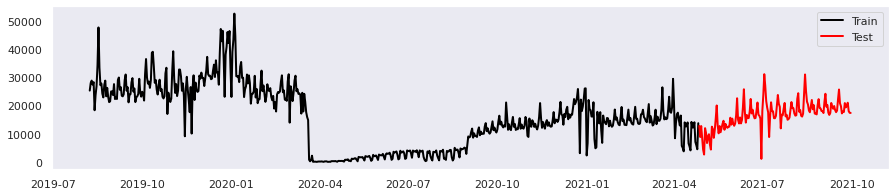

In [146]:
# SE MUESTRA GRAFICAMENTE LA DIVISION DE LOS DATOS EN TRAIN Y TEST
plt.figure(figsize=(15,3))
plt.plot( Train.index.values,Train.PASAJEROS.values, color="black", lw=2, label="Train", )
plt.plot(Test.index.values, Test.PASAJEROS.values, color="red", lw=2, label="Test")
plt.grid();
plt.legend();

## 7.4 Modelos

In [147]:
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
#models.append(('Regresión de Soporte Vectorial', SVR()))

## 7.5 Entrenamiento , prediccion y metricas de desempeño

In [154]:
results = []
names = []
for name, model in models:
  model=model.fit(X_Train,y_Train)
  y_pred= model.predict(X_Test)
  evaluation = evaluate_model(
    model=model,
    metric=mean_absolute_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
  )
  print_report(model=model, evaluation=evaluation)

  cv_results= mean_absolute_error(y_Test,y_pred)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f " % (name, cv_results)
  #print(msg)

Model used:
	LinearRegression()
Error:
	train set MAE: 1338.6405927689445
	test error MAE: 1336.2761070034403
Model used:
	RandomForestRegressor()
Error:
	train set MAE: 405.057101910828
	test error MAE: 1724.2289808917199
Model used:
	KNeighborsRegressor()
Error:
	train set MAE: 1793.9888535031846
	test error MAE: 2712.3796178343946


In [169]:
results1 = []
names1 = []
for name, model in models:
  model=model.fit(X_Train,y_Train)
  y_pred= model.predict(X_Test)
  evaluation = evaluate_model(
    model=model,
    metric=mean_absolute_percentage_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
  )
  print_report(model=model, evaluation=evaluation)
  cv_results= mean_absolute_percentage_error(y_Test,y_pred)
  results1.append(cv_results)
  names1.append(name)
  msg = "%s: %f " % (name, cv_results)
  #print(msg)

Model used:
	LinearRegression()
Error:
	train set MAE: 36.27778154798005
	test error MAE: 16.293646818066406
Model used:
	RandomForestRegressor()
Error:
	train set MAE: 3.1668733139240417
	test error MAE: 17.036105107993784
Model used:
	KNeighborsRegressor()
Error:
	train set MAE: 20.286992970650868
	test error MAE: 20.222663502951207


Comparacion de los modelos

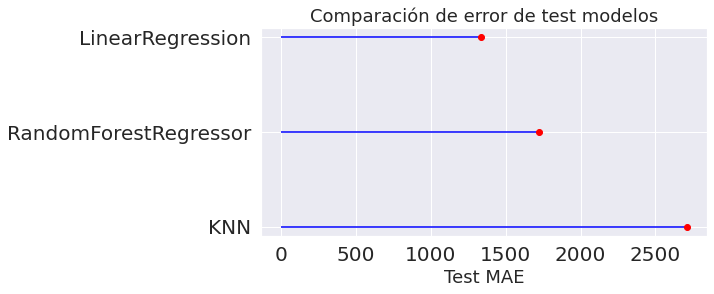

In [159]:
error_modelos = pd.DataFrame({
                        'modelo': ['LinearRegression', 'RandomForestRegressor', 'KNN'],
                        'MAE': [results[0:1][0], results[1:][0], results[2:][0]]
                     })
error_modelos = error_modelos.sort_values('MAE', ascending=False)

fig, ax = plt.subplots(figsize=(8, 3.84))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.MAE,colors="blue")
ax.plot(error_modelos.MAE, error_modelos.modelo, "o", color='red')
ax.tick_params(labelsize=20)
ax.set_title('Comparación de error de test modelos', fontsize=18),
ax.set_xlabel('Test MAE', fontsize=18);

# 8.Primera iteracion


En esta primera iteracion se va a trabajar con los datos utulizados en el Baseline , debido que se vana  utilizar por mismos 10 dias hacia atras , en esta iteracion se intentaara escalar los datos

## 8.1 Copia dataset Baseline

In [160]:
Data_iteracion1=Data_baseline.copy()

In [161]:
Data_iteracion1

,var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),PASAJEROS
FECHA_DESPACHO,,,,,,,,,,,,,,,,
2019-08-08,1986.0,24116.0,2133.0,28542.0,2218.0,32093.0,1900.0,28381.0,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033,25252
2019-08-09,2133.0,28542.0,2218.0,32093.0,1900.0,28381.0,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033.0,25252.0,2135,27944
2019-08-10,2218.0,32093.0,1900.0,28381.0,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033.0,25252.0,2135.0,27944.0,2140,28779
2019-08-11,1900.0,28381.0,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033.0,25252.0,2135.0,27944.0,2140.0,28779.0,1839,27358
2019-08-12,2084.0,28555.0,2084.0,27077.0,1720.0,19443.0,2033.0,25252.0,2135.0,27944.0,2140.0,28779.0,1839.0,27358.0,2094,28246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,1644.0,20772.0,1813.0,19736.0,1711.0,17183.0,1705.0,17876.0,1709.0,17697.0,1767.0,20844.0,1821.0,19307.0,1557,19800
2021-09-27,1813.0,19736.0,1711.0,17183.0,1705.0,17876.0,1709.0,17697.0,1767.0,20844.0,1821.0,19307.0,1557.0,19800.0,1797,20965
2021-09-28,1711.0,17183.0,1705.0,17876.0,1709.0,17697.0,1767.0,20844.0,1821.0,19307.0,1557.0,19800.0,1797.0,20965.0,1718,17965


## 8.2 Escalado de los datos

In [162]:
# SE ESTANDARIZAN LOS DATOS
X= Data_iteracion1.drop(['PASAJEROS'],axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
X[:] = scaler.fit_transform(X)
X["PASAJEROS"] = Data_iteracion1["PASAJEROS"]

In [163]:
X

,var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),PASAJEROS
FECHA_DESPACHO,,,,,,,,,,,,,,,,
2019-08-08,0.735173,0.459280,0.790004,0.543754,0.821708,0.611528,0.703096,0.540681,0.771727,0.544002,0.771727,0.515793,0.635957,0.370093,0.752704,25252
2019-08-09,0.790004,0.543754,0.821708,0.611528,0.703096,0.540681,0.771727,0.544002,0.771727,0.515793,0.635957,0.370093,0.752704,0.480962,0.790750,27944
2019-08-10,0.821708,0.611528,0.703096,0.540681,0.771727,0.544002,0.771727,0.515793,0.635957,0.370093,0.752704,0.480962,0.790750,0.532341,0.792615,28779
2019-08-11,0.703096,0.540681,0.771727,0.544002,0.771727,0.515793,0.635957,0.370093,0.752704,0.480962,0.790750,0.532341,0.792615,0.548278,0.680343,27358
2019-08-12,0.771727,0.544002,0.771727,0.515793,0.635957,0.370093,0.752704,0.480962,0.790750,0.532341,0.792615,0.548278,0.680343,0.521157,0.775457,28246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,0.607609,0.395458,0.670645,0.375685,0.632600,0.326959,0.630362,0.340185,0.631854,0.336769,0.653488,0.396832,0.673629,0.367497,0.575159,19800
2021-09-27,0.670645,0.375685,0.632600,0.326959,0.630362,0.340185,0.631854,0.336769,0.653488,0.396832,0.673629,0.367497,0.575159,0.376906,0.664677,20965
2021-09-28,0.632600,0.326959,0.630362,0.340185,0.631854,0.336769,0.653488,0.396832,0.673629,0.367497,0.575159,0.376906,0.664677,0.399141,0.635211,17965


## 8.3 Division de los datos para entregar y probar modelos

In [164]:
# DIVISION DE LOS DATOS
Train, Test = train_test_split(X, test_size = 0.20, shuffle = False)

# SE CREAN LOS DATOS DE ENTRENAMIENTO Y TEST 
X_Train = Train.drop(columns='PASAJEROS')
y_Train = Train['PASAJEROS']
X_Test= Test.drop(columns='PASAJEROS')
y_Test= Test['PASAJEROS']

## 8.4 Modelos

In [165]:
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
#models.append(('Regresión de Soporte Vectorial', SVR()))

## 8.5 Entrenamiento, Prediccion y metricas de desempeño modelos

In [167]:
results = []
names = []
for name, model in models:
  model=model.fit(X_Train,y_Train)
  y_pred= model.predict(X_Test)
  evaluation = evaluate_model(
    model=model,
    metric=mean_absolute_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
  )
  print_report(model=model, evaluation=evaluation)
  cv_results= mean_absolute_error(y_Test,y_pred)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f " % (name, cv_results)
  #print(msg)

Model used:
	LinearRegression()
Error:
	train set MAE: 1338.6405927689518
	test error MAE: 1336.2761070034462
Model used:
	RandomForestRegressor()
Error:
	train set MAE: 401.7225796178344
	test error MAE: 1714.7634394904458
Model used:
	KNeighborsRegressor()
Error:
	train set MAE: 1341.9140127388534
	test error MAE: 2198.541401273885


In [170]:
results1 = []
names1 = []
for name, model in models:
  model=model.fit(X_Train,y_Train)
  y_pred= model.predict(X_Test)
  evaluation = evaluate_model(
    model=model,
    metric=mean_absolute_percentage_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
  )
  print_report(model=model, evaluation=evaluation)
  cv_results= mean_absolute_percentage_error(y_Test,y_pred)
  results1.append(cv_results)
  names1.append(name)
  msg = "%s: %f " % (name, cv_results)
  #print(msg)

Model used:
	LinearRegression()
Error:
	train set MAE: 36.27778154798005
	test error MAE: 16.293646818066406
LinearRegression: 16.293647 
Model used:
	RandomForestRegressor()
Error:
	train set MAE: 3.1074272992461425
	test error MAE: 16.91771778169664
RandomForestRegressor: 16.917718 
Model used:
	KNeighborsRegressor()
Error:
	train set MAE: 20.286992970650868
	test error MAE: 20.222663502951207
KNN: 20.222664 


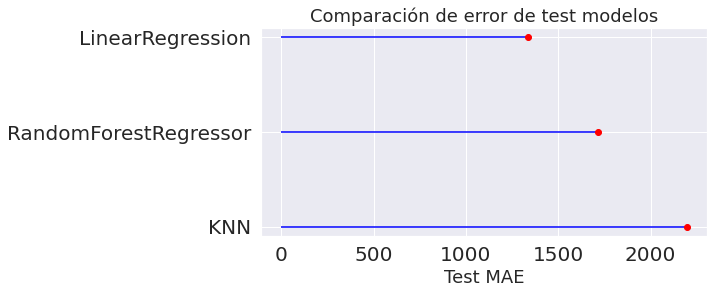

In [171]:
error_modelos = pd.DataFrame({
                        'modelo': ['LinearRegression', 'RandomForestRegressor', 'KNN'],
                        'MAE': [results[0:1][0], results[1:][0], results[2:][0]]
                     })
error_modelos = error_modelos.sort_values('MAE', ascending=False)

fig, ax = plt.subplots(figsize=(8, 3.84))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.MAE,colors="blue")
ax.plot(error_modelos.MAE, error_modelos.modelo, "o", color='red')
ax.tick_params(labelsize=20)
ax.set_title('Comparación de error de test modelos', fontsize=18),
ax.set_xlabel('Test MAE', fontsize=18);

# 9.Segunda iteracion

En esta iteracion se van han crear dos predictoras mas , una que corresponde a la COLUMNA DAY: la cual identifica que dia de la semana es , y la otraa es HOLIDAY : Que casifica si es fin de semana o festivo

## 9.1 Copia del dataset original para segunda iteracion

In [172]:
Data_iteracion2= Data.copy()

## 9.2 Se crea una columna llamada "FECHA_DESPACHO"

In [173]:
# Se crea una Columna con el indice de la fecha
Data_iteracion2['FECHA_DESPACHO']=Data_iteracion2.index

### 9.2.1 Se cambia el formato de la columna creada

In [174]:
# Se le cambia el formato a la columna FECHA_DESPAACHO
Data_iteracion2['FECHA_DESPACHO'] = Data_iteracion2['FECHA_DESPACHO'].dt.strftime('%Y/%m/%d')

## 9.3 Se crean dos columnas DAY: permite indificar que dia de la semana es  y HOLIDAY: Clasifrica que el dia es festivo o es fin de semana 

In [175]:
# Com la siguiente celda se identifica los dias y si son fines de semana y festivos  0:lunes, 1:Martes, 2: Miercoles, 3:Jueves, 4 : viernes, 5 : Sabado, 6 Domingo 
Fechas=list(Data_iteracion2.FECHA_DESPACHO)
DiaSemana=[]
Holiday=[]
for i in range(len(Fechas)):
  dt=Fechas[i]
  year, month, day = (int(x) for x in dt.split('/'))  
  ans = datetime.date(year, month, day)
  if holidays_co.is_holiday_date(ans)==True:
    Holiday.append(1)
  else:
    Holiday.append(0)
  if ans.weekday()==6:
    Holiday[i]=2
  if ans.weekday()==5:
    Holiday[i]=3
  DiaSemana.append(ans.weekday()) 

In [176]:
 #Se crea dos colunas con la que se identifica el dia y se es fin desemna o festivo
 Data_iteracion2.insert(1,'Day',DiaSemana,True)
 Data_iteracion2.insert(2,'Holiday',Holiday,True)

In [177]:
Data_iteracion2.head()

,DESPACHOS,Day,Holiday,PASAJEROS,FECHA_DESPACHO
FECHA_DESPACHO,,,,,
2019-08-01,1986,3,0,24116,2019/08/01
2019-08-02,2133,4,0,28542,2019/08/02
2019-08-03,2218,5,3,32093,2019/08/03
2019-08-04,1900,6,2,28381,2019/08/04
2019-08-05,2084,0,0,28555,2019/08/05


In [178]:
Data_iteracion2.shape

(792, 5)

Se elimna la columna FECHA_DESPACHO , ya que no se volvera a utilizar

In [179]:
# SE ELINA LA COLUMNA FECHA_DESPACHO DEBIDO QUE NO SE VA A UTILIZAR NUEVAMENTE , SOLO NSE DEJO PARA IDENTIFICAR EL DIA Y SI ERA FESTIVO
Data_iteracion2=Data_iteracion2.drop(["FECHA_DESPACHO"], axis=1)

In [180]:
Data_final=Data_iteracion2.copy()

## 9.4 Escalado de datos

In [181]:
# SE ESTANDARIZAN LOS DATOS
X= Data_iteracion2.drop(['PASAJEROS'],axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
X[:] = scaler.fit_transform(X)
X["PASAJEROS"] = Data_iteracion2["PASAJEROS"]

## 9.5 Transformar dartos de la series a unos datos para un algoritmo de aprendizaje supervisado

In [182]:
step_back = 7
Data_iteracion2 = series_to_supervised(X,step_back,1)

In [183]:
Data_iteracion2.shape

(785, 32)

In [184]:
Data_iteracion2.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
FECHA_DESPACHO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-08,0.735173,0.500000,0.000000,24116.0,0.790004,0.666667,0.000000,28542.0,0.821708,0.833333,1.000000,32093.0,0.703096,1.000000,0.666667,28381.0,0.771727,0.000000,0.000000,28555.0,0.771727,0.166667,0.000000,27077.0,0.635957,0.333333,0.333333,19443.0,0.752704,0.500000,0.000000,25252
2019-08-09,0.790004,0.666667,0.000000,28542.0,0.821708,0.833333,1.000000,32093.0,0.703096,1.000000,0.666667,28381.0,0.771727,0.000000,0.000000,28555.0,0.771727,0.166667,0.000000,27077.0,0.635957,0.333333,0.333333,19443.0,0.752704,0.500000,0.000000,25252.0,0.790750,0.666667,0.000000,27944
2019-08-10,0.821708,0.833333,1.000000,32093.0,0.703096,1.000000,0.666667,28381.0,0.771727,0.000000,0.000000,28555.0,0.771727,0.166667,0.000000,27077.0,0.635957,0.333333,0.333333,19443.0,0.752704,0.500000,0.000000,25252.0,0.790750,0.666667,0.000000,27944.0,0.792615,0.833333,1.000000,28779
2019-08-11,0.703096,1.000000,0.666667,28381.0,0.771727,0.000000,0.000000,28555.0,0.771727,0.166667,0.000000,27077.0,0.635957,0.333333,0.333333,19443.0,0.752704,0.500000,0.000000,25252.0,0.790750,0.666667,0.000000,27944.0,0.792615,0.833333,1.000000,28779.0,0.680343,1.000000,0.666667,27358
2019-08-12,0.771727,0.000000,0.000000,28555.0,0.771727,0.166667,0.000000,27077.0,0.635957,0.333333,0.333333,19443.0,0.752704,0.500000,0.000000,25252.0,0.790750,0.666667,0.000000,27944.0,0.792615,0.833333,1.000000,28779.0,0.680343,1.000000,0.666667,27358.0,0.775457,0.000000,0.000000,28246


In [185]:
Data_iteracion2=Data_iteracion2.rename(columns={'var4(t)':'PASAJEROS'})

## 9.6 Division de los datos para entrenar y probar modelos

In [186]:
# DIVISION DE LOS DATOS
Train, Test = train_test_split(Data_iteracion2, test_size = 0.20, shuffle = False)

# SE CREAN LOS DATOS DE ENTRENAMIENTO Y TEST 
X_Train = Train.drop(columns='PASAJEROS')
y_Train = Train['PASAJEROS']
X_Test= Test.drop(columns='PASAJEROS')
y_Test= Test['PASAJEROS']

In [187]:
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
#models.append(('Regresión de Soporte Vectorial', SVR()))

In [189]:
results = []
names = []
for name, model in models:
  model=model.fit(X_Train,y_Train)
  y_pred= model.predict(X_Test)
  evaluation = evaluate_model(
    model=model,
    metric=mean_absolute_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
  )
  print_report(model=model, evaluation=evaluation)
  cv_results= mean_absolute_error(y_Test,y_pred)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f " % (name, cv_results)
  #print(msg)

Model used:
	LinearRegression()
Error:
	train set MAE: 1251.0196997919384
	test error MAE: 1128.9380084641855
Model used:
	RandomForestRegressor()
Error:
	train set MAE: 395.29297770700634
	test error MAE: 1718.9791082802546
Model used:
	KNeighborsRegressor()
Error:
	train set MAE: 1803.7611464968154
	test error MAE: 2690.39872611465


In [192]:
results1 = []
names1 = []
for name, model in models:
  model=model.fit(X_Train,y_Train)
  y_pred= model.predict(X_Test)
  evaluation = evaluate_model(
    model=model,
    metric=mean_absolute_percentage_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
  )
  print_report(model=model, evaluation=evaluation)
  cv_results= mean_absolute_percentage_error(y_Test,y_pred)
  results1.append(cv_results)
  names1.append(name)
  msg = "%s: %f " % (name, cv_results)
  #print(msg)

Model used:
	LinearRegression()
Error:
	train set MAE: 53.85187976902157
	test error MAE: 15.263451313268511
Model used:
	RandomForestRegressor()
Error:
	train set MAE: 3.2576657664034148
	test error MAE: 17.0750783925014
Model used:
	KNeighborsRegressor()
Error:
	train set MAE: 46.52747115841948
	test error MAE: 25.05037190322847


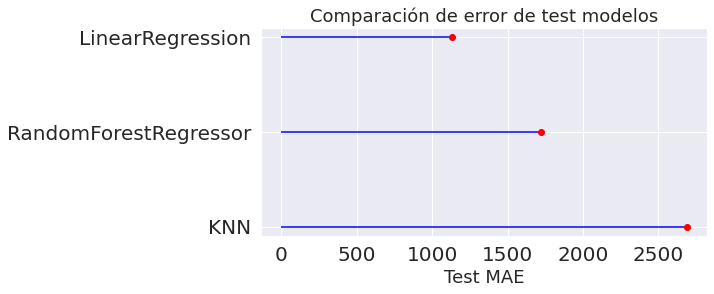

In [191]:
error_modelos = pd.DataFrame({
                        'modelo': ['LinearRegression', 'RandomForestRegressor', 'KNN'],
                        'MAE': [results[0:1][0], results[1:][0], results[2:][0]]
                     })
error_modelos = error_modelos.sort_values('MAE', ascending=False)

fig, ax = plt.subplots(figsize=(8, 3.84))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.MAE,colors="blue")
ax.plot(error_modelos.MAE, error_modelos.modelo, "o", color='red')
ax.tick_params(labelsize=20)
ax.set_title('Comparación de error de test modelos', fontsize=18),
ax.set_xlabel('Test MAE', fontsize=18);

# 10.Tercera iteracion


## 10.1 Teniendo en cuenta el analisis exploratorio realizado en el numeral 4 , se quiso trabajar con datos a partir de octobre de 2020

In [193]:
# SE FILTRA PARA TRABAJAR SOLO CON DATOS A PARTIR DE ABRIL DE 2020
Data_final= Data_final["2020-10":]

In [194]:
Data_final

,DESPACHOS,Day,Holiday,PASAJEROS
FECHA_DESPACHO,,,,
2020-10-01,1507,3,0,11486
2020-10-02,1605,4,0,14293
2020-10-03,1712,5,3,16371
2020-10-04,1424,6,2,13247
2020-10-05,1628,0,0,14250
...,...,...,...,...
2021-09-26,1557,6,2,19800
2021-09-27,1797,0,0,20965
2021-09-28,1718,1,0,17965


## 10.2 Transformar dartos de la series a unos datos para un algoritmo de aprendizaje supervisado

In [195]:
step_back = 7
Data_iteracion3 = series_to_supervised(Data_final,step_back,1)

In [196]:
Data_iteracion3

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
FECHA_DESPACHO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-08,1507.0,3.0,0.0,11486.0,1605.0,4.0,0.0,14293.0,1712.0,5.0,3.0,16371.0,1424.0,6.0,2.0,13247.0,1628.0,0.0,0.0,14250.0,1536.0,1.0,0.0,12781.0,1528.0,2.0,0.0,12240.0,1550,3,0,13015
2020-10-09,1605.0,4.0,0.0,14293.0,1712.0,5.0,3.0,16371.0,1424.0,6.0,2.0,13247.0,1628.0,0.0,0.0,14250.0,1536.0,1.0,0.0,12781.0,1528.0,2.0,0.0,12240.0,1550.0,3.0,0.0,13015.0,1678,4,0,12520
2020-10-10,1712.0,5.0,3.0,16371.0,1424.0,6.0,2.0,13247.0,1628.0,0.0,0.0,14250.0,1536.0,1.0,0.0,12781.0,1528.0,2.0,0.0,12240.0,1550.0,3.0,0.0,13015.0,1678.0,4.0,0.0,12520.0,1979,5,3,21045
2020-10-11,1424.0,6.0,2.0,13247.0,1628.0,0.0,0.0,14250.0,1536.0,1.0,0.0,12781.0,1528.0,2.0,0.0,12240.0,1550.0,3.0,0.0,13015.0,1678.0,4.0,0.0,12520.0,1979.0,5.0,3.0,21045.0,1599,6,2,16271
2020-10-12,1628.0,0.0,0.0,14250.0,1536.0,1.0,0.0,12781.0,1528.0,2.0,0.0,12240.0,1550.0,3.0,0.0,13015.0,1678.0,4.0,0.0,12520.0,1979.0,5.0,3.0,21045.0,1599.0,6.0,2.0,16271.0,1446,0,1,11397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,1644.0,6.0,2.0,20772.0,1813.0,0.0,0.0,19736.0,1711.0,1.0,0.0,17183.0,1705.0,2.0,0.0,17876.0,1709.0,3.0,0.0,17697.0,1767.0,4.0,0.0,20844.0,1821.0,5.0,3.0,19307.0,1557,6,2,19800
2021-09-27,1813.0,0.0,0.0,19736.0,1711.0,1.0,0.0,17183.0,1705.0,2.0,0.0,17876.0,1709.0,3.0,0.0,17697.0,1767.0,4.0,0.0,20844.0,1821.0,5.0,3.0,19307.0,1557.0,6.0,2.0,19800.0,1797,0,0,20965
2021-09-28,1711.0,1.0,0.0,17183.0,1705.0,2.0,0.0,17876.0,1709.0,3.0,0.0,17697.0,1767.0,4.0,0.0,20844.0,1821.0,5.0,3.0,19307.0,1557.0,6.0,2.0,19800.0,1797.0,0.0,0.0,20965.0,1718,1,0,17965


In [197]:
Data_iteracion3.shape

(358, 32)

In [198]:
Data_iteracion3=Data_iteracion3.rename(columns={'var4(t)':'PASAJEROS'})

## 10.3 Se escalan los datos y se dividen en entrenamiento y prueba de los modelos

In [199]:
# SE ESTANDARIZAN LOS DATOS
X= Data_iteracion3.drop(['PASAJEROS'],axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
X[:] = scaler.fit_transform(X)
X["PASAJEROS"] = Data_iteracion3["PASAJEROS"]

# DIVISION DE LOS DATOS
Train, Test = train_test_split(X, test_size = 0.11, shuffle = False)

# SE CREAN LOS DATOS DE ENTRENAMIENTO Y TEST 
X_Train = Train.drop(columns='PASAJEROS')
y_Train = Train['PASAJEROS']
X_Test= Test.drop(columns='PASAJEROS')
y_Test= Test['PASAJEROS']

## 10.4 Modelos

In [200]:
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
#models.append(('Regresión de Soporte Vectorial', SVR()))

## 10.5  Entrenamiento, Prediccion y metricas de desempeño modelos

In [203]:
results = []
names = []
for name, model in models:
  model=model.fit(X_Train,y_Train)
  y_pred= model.predict(X_Test)
  evaluation = evaluate_model(
    model=model,
    metric=mean_absolute_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
  )
  print_report(model=model, evaluation=evaluation)
  cv_results= mean_absolute_error(y_Test,y_pred)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f " % (name, cv_results)
  #print(msg)

Model used:
	LinearRegression()
Error:
	train set MAE: 932.5037272179196
	test error MAE: 766.3835432855024
Model used:
	RandomForestRegressor()
Error:
	train set MAE: 430.7760377358492
	test error MAE: 871.4124999999997
Model used:
	KNeighborsRegressor()
Error:
	train set MAE: 1689.822012578616
	test error MAE: 1138.2949999999996


In [204]:
results1 = []
names1 = []
for name, model in models:
  model=model.fit(X_Train,y_Train)
  y_pred= model.predict(X_Test)
  evaluation = evaluate_model(
    model=model,
    metric=mean_absolute_percentage_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
  )
  print_report(model=model, evaluation=evaluation)
  cv_results= mean_absolute_percentage_error(y_Test,y_pred)
  results1.append(cv_results)
  names1.append(name)
  msg = "%s: %f " % (name, cv_results)
  #print(msg)

Model used:
	LinearRegression()
Error:
	train set MAE: 10.781446537331774
	test error MAE: 3.9991351368947834
Model used:
	RandomForestRegressor()
Error:
	train set MAE: 4.278475944099131
	test error MAE: 4.441434033431625
Model used:
	KNeighborsRegressor()
Error:
	train set MAE: 17.1890486253584
	test error MAE: 5.989669206085505


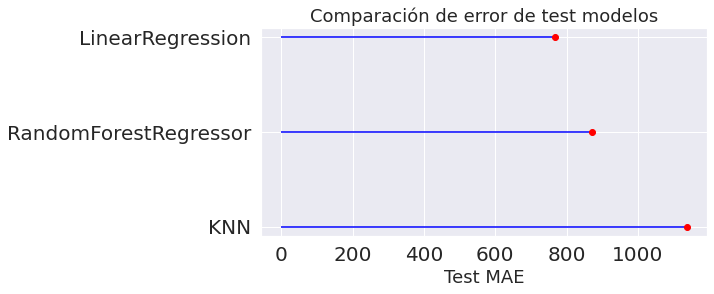

In [205]:
error_modelos = pd.DataFrame({
                        'modelo': ['LinearRegression', 'RandomForestRegressor', 'KNN'],
                        'MAE': [results[0:1][0], results[1:][0], results[2:][0]]
                     })
error_modelos = error_modelos.sort_values('MAE', ascending=False)

fig, ax = plt.subplots(figsize=(8, 3.84))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.MAE,colors="blue")
ax.plot(error_modelos.MAE, error_modelos.modelo, "o", color='red')
ax.tick_params(labelsize=20)
ax.set_title('Comparación de error de test modelos', fontsize=18),
ax.set_xlabel('Test MAE', fontsize=18);

# 11.Cuarta iteracion

In [271]:
Data_final

,DESPACHOS,Day,Holiday,PASAJEROS
FECHA_DESPACHO,,,,
2020-10-01,1507,3,0,11486
2020-10-02,1605,4,0,14293
2020-10-03,1712,5,3,16371
2020-10-04,1424,6,2,13247
2020-10-05,1628,0,0,14250
...,...,...,...,...
2021-09-26,1557,6,2,19800
2021-09-27,1797,0,0,20965
2021-09-28,1718,1,0,17965


In [272]:
Data_iteracionfinal= Data_final.copy()

## 11.1 Se escalan los datos

In [273]:
X= Data_iteracionfinal.drop(['PASAJEROS'],axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
X[:] = scaler.fit_transform(X)
X["PASAJEROS"] = Data_iteracionfinal["PASAJEROS"]

## 11.2 Transformar dartos de la series a unos datos para un algoritmo de aprendizaje supervisado

In [274]:
step_back = 7
Data_iteracionfinal = series_to_supervised(X,step_back,1)

In [275]:
Data_iteracionfinal.head()

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
FECHA_DESPACHO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-08,0.683437,0.500000,0.000000,11486.0,0.738836,0.666667,0.000000,14293.0,0.799322,0.833333,1.000000,16371.0,0.636518,1.000000,0.666667,13247.0,0.751837,0.000000,0.0,14250.0,0.699830,0.166667,0.0,12781.0,0.695308,0.333333,0.000000,12240.0,0.707744,0.500000,0.000000,13015
2020-10-09,0.738836,0.666667,0.000000,14293.0,0.799322,0.833333,1.000000,16371.0,0.636518,1.000000,0.666667,13247.0,0.751837,0.000000,0.000000,14250.0,0.699830,0.166667,0.0,12781.0,0.695308,0.333333,0.0,12240.0,0.707744,0.500000,0.000000,13015.0,0.780102,0.666667,0.000000,12520
2020-10-10,0.799322,0.833333,1.000000,16371.0,0.636518,1.000000,0.666667,13247.0,0.751837,0.000000,0.000000,14250.0,0.699830,0.166667,0.000000,12781.0,0.695308,0.333333,0.0,12240.0,0.707744,0.500000,0.0,13015.0,0.780102,0.666667,0.000000,12520.0,0.950254,0.833333,1.000000,21045
2020-10-11,0.636518,1.000000,0.666667,13247.0,0.751837,0.000000,0.000000,14250.0,0.699830,0.166667,0.000000,12781.0,0.695308,0.333333,0.000000,12240.0,0.707744,0.500000,0.0,13015.0,0.780102,0.666667,0.0,12520.0,0.950254,0.833333,1.000000,21045.0,0.735444,1.000000,0.666667,16271
2020-10-12,0.751837,0.000000,0.000000,14250.0,0.699830,0.166667,0.000000,12781.0,0.695308,0.333333,0.000000,12240.0,0.707744,0.500000,0.000000,13015.0,0.780102,0.666667,0.0,12520.0,0.950254,0.833333,1.0,21045.0,0.735444,1.000000,0.666667,16271.0,0.648954,0.000000,0.333333,11397


In [276]:
Data_iteracionfinal=Data_iteracionfinal.rename(columns={'var4(t)':'PASAJEROS'})

In [277]:
Data_iteracionfinal.shape

(358, 32)

In [ ]:
#X=Data_iteracionfinal.drop(['PASAJEROS'],axis=1)
#y=Data_iteracionfinal['PASAJEROS']

## 11.3 Division de los datos para entrenar y probar modelos

In [278]:
# DIVISION DE LOS DATOS
Train, Test = train_test_split(Data_iteracionfinal, test_size = 0.20, shuffle = False)

# SE CREAN LOS DATOS DE ENTRENAMIENTO Y TEST 
X_Train = Train.drop(columns='PASAJEROS')
y_Train = Train['PASAJEROS']
X_Test= Test.drop(columns='PASAJEROS')
y_Test= Test['PASAJEROS']

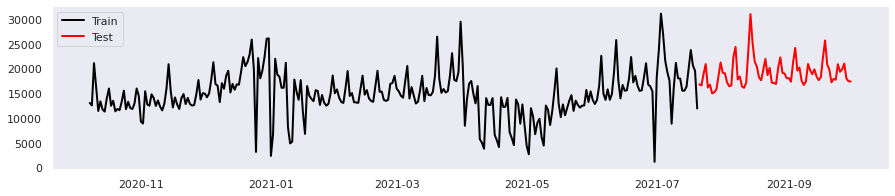

In [279]:
# SE MUESTRA GRAFICAMENTE LA DIVISION DE LOS DATOS EN TRAIN Y TEST
plt.figure(figsize=(15,3))
plt.plot( Train.index.values,Train.PASAJEROS.values, color="black", lw=2, label="Train", )
plt.plot(Test.index.values, Test.PASAJEROS.values, color="red", lw=2, label="Test")
plt.grid();
plt.legend();

## 11.4 Modelos

### 11.4.1 LinearRegression con validacion cruzada

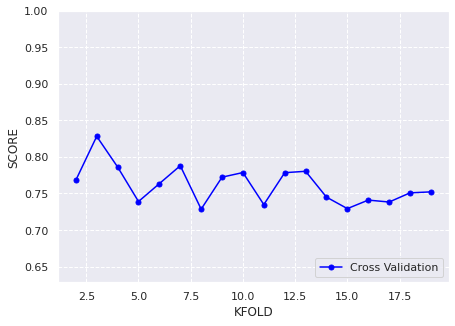

In [280]:
train_scores = []
models = [] 
mae = [] 
 
for KF in range(2,20):
    lin3 = LinearRegression()
    linea= lin3.fit(X_Train,y_Train)
    kf = KFold(n_splits=KF)
    scores = cross_val_score(linea, X_Train, y_Train, cv=kf) #pasamos el modelo entrenado, x train, y train y kfold para cada iteraciion
    train_scores.append(scores.mean())
    models.append(lin3)
    y_pred2=lin3.predict(X_Test)
    mae.append(mean_absolute_error(y_Test,y_pred2)) 
 
 
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(
    range(2,20), train_scores, color='blue',
    marker='o', linestyle='-', markersize=5, 
    label='Cross Validation'
)
 
 
ax.set_xlabel('KFOLD')
ax.set_ylabel('SCORE')
ax.set_ylim((min(train_scores)) - 0.1, 1)
ax.grid(linestyle='--')
ax.legend(loc='lower right')

In [281]:
best = np.argmax(train_scores)

#### 11.4.1.1 Metricas desempeño

In [282]:
mean_absolute_percentage_error_lm=mean_absolute_percentage_error(y_Test,y_pred2)

In [283]:
mean_absolute_error_lm=mean_absolute_error(y_Test,y_pred2)

In [284]:
mean_absolute_error_lm

761.4731530576252

In [285]:
evaluation = evaluate_model(
    model=models[best],
    metric=mean_absolute_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
)
print_report(model=models[best], evaluation=evaluation)

Model used:
	LinearRegression()
Error:
	train set MAE: 953.4314470893396
	test error MAE: 761.4731530576252


In [286]:
evaluation = evaluate_model(
    model=models[best],
    metric=mean_absolute_percentage_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
)
print_report(model=models[best], evaluation=evaluation)

Model used:
	LinearRegression()
Error:
	train set MAE: 11.507213162017289
	test error MAE: 3.8481239963771148


#### 11.4.1.2 Graficar resultados

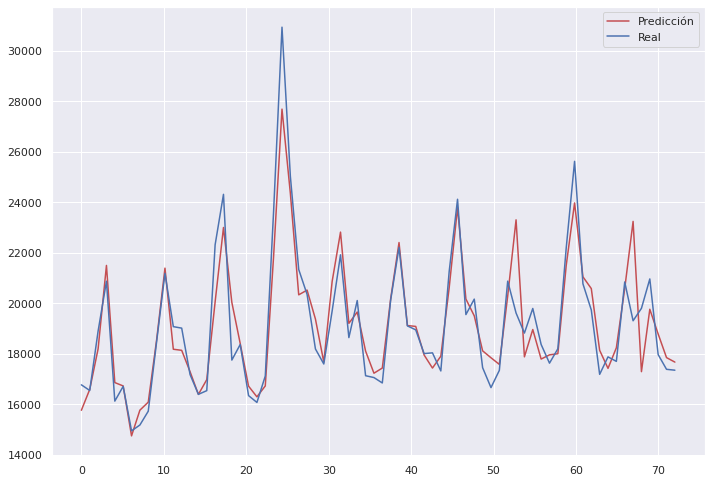

In [287]:
plt.plot(np.linspace(0,len(y_pred2),len(y_pred2)),y_pred2,'r',label='Predicción')
plt.plot(np.linspace(0,len(y_Test),len(y_Test)),y_Test,'b',label='Real')
plt.legend()
plt.show()

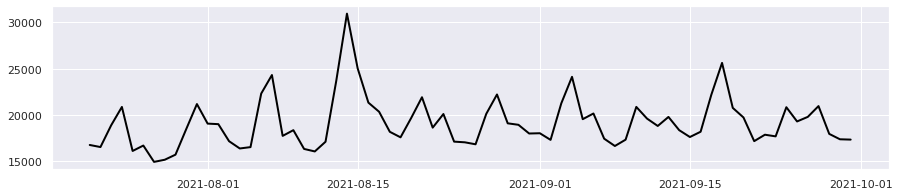

In [288]:
plt.figure(figsize=(15,3))
plt.plot(y_Test.index.values,y_Test.values, color="black", lw=2, label="Train", )

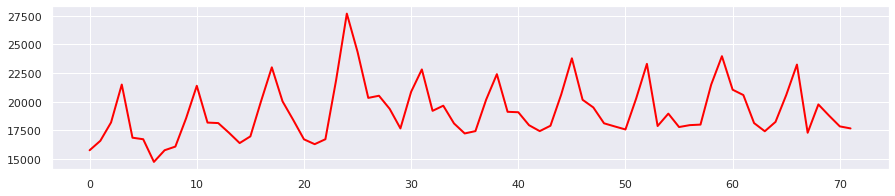

In [289]:
plt.figure(figsize=(15,3))
plt.plot(y_pred2 , color="red", lw=2, label="Test")

In [224]:
df_predicciones_linear= pd.DataFrame({'PASAJEROS_Real' : y_Test, 'PASAJEROS_Prediccion' : y_pred2})
df_predicciones_linear['diferencia'] = df_predicciones_linear['PASAJEROS_Real'] - df_predicciones_linear['PASAJEROS_Prediccion']
df_predicciones_linear["2021-09"]

,PASAJEROS_Real,PASAJEROS_Prediccion,diferencia
FECHA_DESPACHO,,,
2021-09-01,18035,17432.680611,602.319389
2021-09-02,17318,17902.514348,-584.514348
2021-09-03,21262,20618.003332,643.996668
2021-09-04,24123,23792.322232,330.677768
2021-09-05,19552,20170.014035,-618.014035
2021-09-06,20165,19501.428754,663.571246
2021-09-07,17448,18114.840398,-666.840398
2021-09-08,16658,17840.935084,-1182.935084
2021-09-09,17341,17577.807398,-236.807398


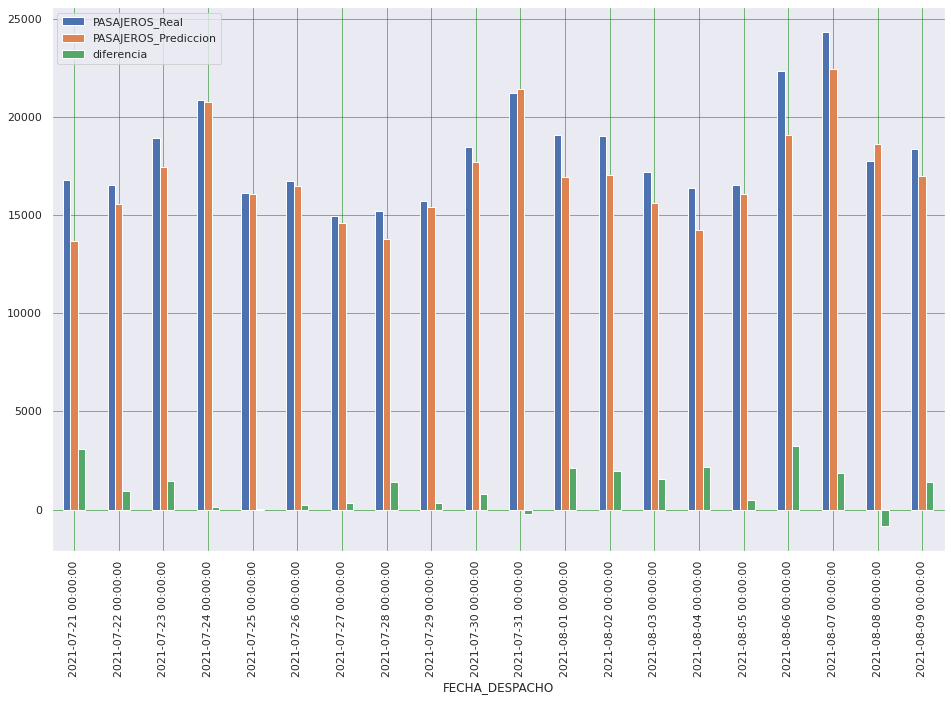

In [290]:
df_predicciones_linear = df_predicciones_linear.head(20)
df_predicciones_linear.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [119]:
from sklearn.linear_model import Ridge

In [120]:
model = Ridge(alpha = 0.5, normalize = False, tol = 0.001, \
              solver ='auto', random_state = 42)

In [121]:
model.fit(X_Train,y_Train)

Ridge(alpha=0.5, normalize=False, random_state=42)

In [122]:
y_pred_ridge=model.predict(X_Test)

In [123]:
mean_absolute_error_lm=mean_absolute_error(y_Test,y_pred_ridge)

In [124]:
mean_absolute_error_lm

837.0179445694147

### 11.4.2 RandomForestRegressor con validazion cruzada y busqueda de hiperparametrsos

In [226]:
# Grid de hiperparámetros evaluados
# ==============================================================================


param_grid = {'n_estimators': [100,150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), # cross validation
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )



grid.fit(X = X_Train, y = y_Train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
17,10,9,150,-2315.467706,395.896830,-908.457230,37.863196
16,10,9,100,-2326.664783,401.185086,-923.335960,42.458188
5,None,9,150,-2335.202942,403.526834,-879.947306,34.861709
23,20,9,150,-2338.531591,405.062252,-879.784731,35.800585


In [245]:
modelo_final = grid.best_estimator_

In [246]:
y_pred3=modelo_final.predict(X_Test)

#### 11.4.2.1 Metricas

In [247]:
mean_absolute_percentage_error_bosque=mean_absolute_percentage_error(y_Test,y_pred3)

In [248]:
mean_absolute_error_bosque=mean_absolute_error(y_Test,y_pred3)

In [249]:
evaluation = evaluate_model(
    model=modelo_final,
    metric=mean_absolute_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
)
print_report(model=modelo_final, evaluation=evaluation)

Model used:
	KNeighborsRegressor(n_neighbors=12, p=1, weights='distance')
Error:
	train set MAE: 0.0
	test error MAE: 1638.5094840962245


In [250]:
evaluation = evaluate_model(
    model=modelo_final,
    metric=mean_absolute_percentage_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
)
print_report(model=modelo_final, evaluation=evaluation)

Model used:
	KNeighborsRegressor(n_neighbors=12, p=1, weights='distance')
Error:
	train set MAE: 0.0
	test error MAE: 7.842788073811358


#### 11.4.2.2 Graficar resultados

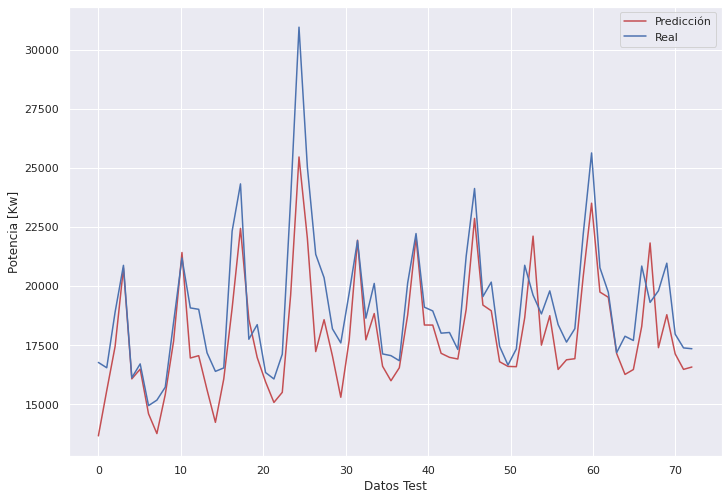

In [233]:
plt.plot(np.linspace(0,len(y_pred3),len(y_pred3)),y_pred3,'r',label='Predicción')
plt.plot(np.linspace(0,len(y_Test),len(y_Test)),y_Test,'b',label='Real')
plt.xlabel('Datos Test')
plt.ylabel('Potencia [Kw]')
#plt.title(f'Predicción para la hora {Hora_Proyectar}')
plt.legend()
plt.show()

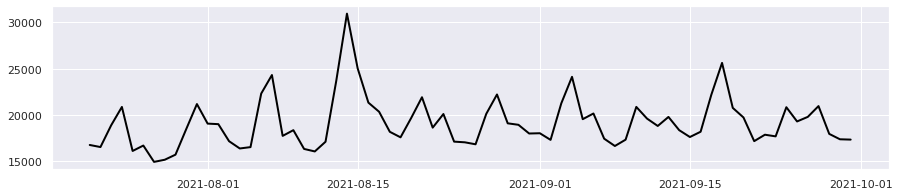

In [234]:
plt.figure(figsize=(15,3))
plt.plot(y_Test.index.values,y_Test.values, color="black", lw=2, label="Train", )

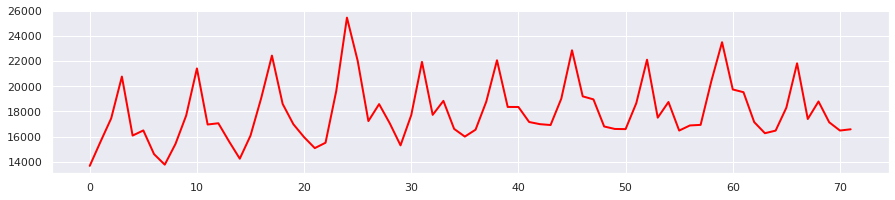

In [235]:
plt.figure(figsize=(15,3))
plt.plot(y_pred3 , color="red", lw=2, label="Test")

In [236]:
df_predicciones_linear= pd.DataFrame({'PASAJEROS_Real' : y_Test, 'PASAJEROS_Prediccion' : y_pred3})
df_predicciones_linear['diferencia'] = df_predicciones_linear['PASAJEROS_Real'] - df_predicciones_linear['PASAJEROS_Prediccion']
df_predicciones_linear["2021-09"]

,PASAJEROS_Real,PASAJEROS_Prediccion,diferencia
FECHA_DESPACHO,,,
2021-09-01,18035,16983.191401,1051.808599
2021-09-02,17318,16913.836573,404.163427
2021-09-03,21262,19012.763310,2249.236690
2021-09-04,24123,22858.681710,1264.318290
2021-09-05,19552,19194.595665,357.404335
2021-09-06,20165,18953.898859,1211.101141
2021-09-07,17448,16797.722331,650.277669
2021-09-08,16658,16600.950573,57.049427
2021-09-09,17341,16588.823206,752.176794


### 11.4.3 KNeighborsRegressor con validacion creuzada y busqueda de hiperparametros

In [237]:
# Grid de hiperparámetros evaluados
# ==============================================================================


param_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'weights': ['uniform','distance'],
              'p':[1,2,5]}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = KNeighborsRegressor(),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )



grid.fit(X = X_Train, y = y_Train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_n_neighbors,param_p,param_weights,mean_test_score,std_test_score,mean_train_score,std_train_score
61,12,1,distance,-3506.870049,551.200857,0.0,0.0
73,14,1,distance,-3510.231836,568.006880,0.0,0.0
67,13,1,distance,-3511.450269,563.295125,0.0,0.0
55,11,1,distance,-3511.613915,559.856037,0.0,0.0


In [238]:
modelo_final_KNN = grid.best_estimator_

In [239]:
y_pred4=modelo_final_KNN.predict(X_Test)

#### 11.4.3.1 Metricas

In [240]:
mean_absolute_percentage_error_KNN=mean_absolute_percentage_error(y_Test,y_pred4)

In [241]:
mean_absolute_error_KNN=mean_absolute_error(y_Test,y_pred4)

In [243]:
evaluation = evaluate_model(
    model=modelo_final_KNN,
    metric=mean_absolute_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
)
print_report(model=modelo_final_KNN, evaluation=evaluation)

Model used:
	KNeighborsRegressor(n_neighbors=12, p=1, weights='distance')
Error:
	train set MAE: 0.0
	test error MAE: 1638.5094840962245


In [244]:
evaluation = evaluate_model(
    model=modelo_final_KNN,
    metric=mean_absolute_percentage_error,
    X_train=X_Train,
    y_train=y_Train,
    X_test=X_Test,
    y_test=y_Test
)
print_report(model=modelo_final_KNN, evaluation=evaluation)

Model used:
	KNeighborsRegressor(n_neighbors=12, p=1, weights='distance')
Error:
	train set MAE: 0.0
	test error MAE: 7.842788073811358


#### 11.4.3.2 Graficas resultados

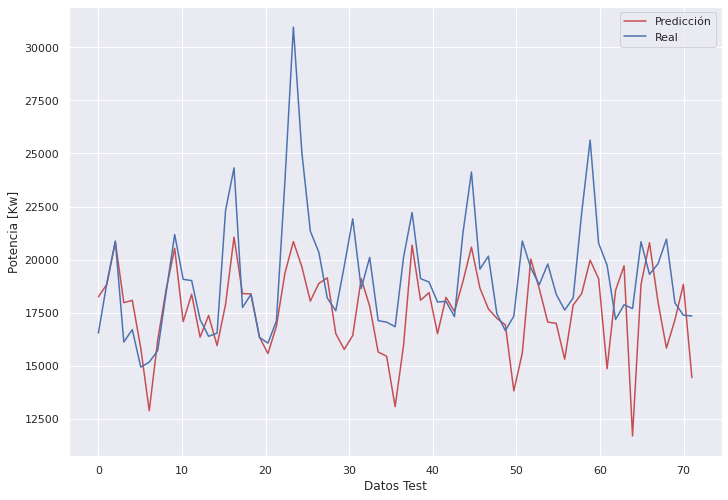

In [ ]:
plt.plot(np.linspace(0,len(y_pred4),len(y_pred4)),y_pred4,'r',label='Predicción')
plt.plot(np.linspace(0,len(y_Test),len(y_Test)),y_Test,'b',label='Real')
plt.xlabel('Datos Test')
plt.ylabel('Potencia [Kw]')
#plt.title(f'Predicción para la hora {Hora_Proyectar}')
plt.legend()
plt.show()

In [ ]:
df_predicciones_linear= pd.DataFrame({'PASAJEROS_Real' : y_Test, 'PASAJEROS_Prediccion' : y_pred4})
df_predicciones_linear['diferencia'] = df_predicciones_linear['PASAJEROS_Real'] - df_predicciones_linear['PASAJEROS_Prediccion']
df_predicciones_linear["2021-09"]

,PASAJEROS_Real,PASAJEROS_Prediccion,diferencia
FECHA_DESPACHO,,,
2021-09-01,18035.0,18226.189054,-191.189054
2021-09-02,17318.0,17555.829465,-237.829465
2021-09-03,21262.0,18977.024629,2284.975371
2021-09-04,24123.0,20590.331019,3532.668981
2021-09-05,19552.0,18662.574483,889.425517
2021-09-06,20165.0,17682.434293,2482.565707
2021-09-07,17448.0,17238.019807,209.980193
2021-09-08,16658.0,16928.891199,-270.891199
2021-09-09,17341.0,13819.443267,3521.556733


Comparacionm resultados modelos cuarta iteracion


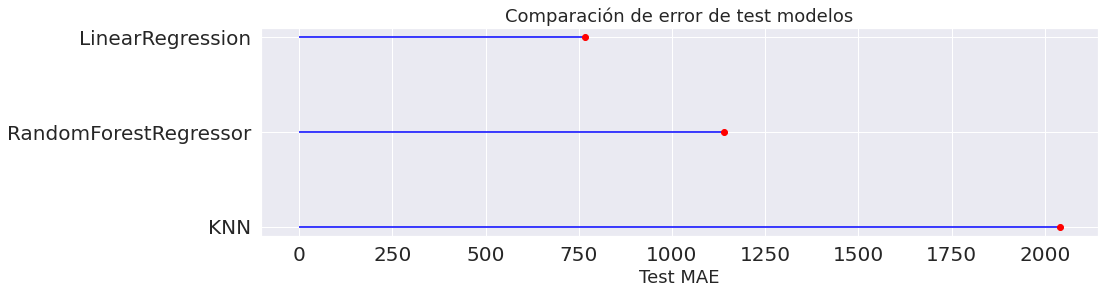

In [ ]:
error_modelos = pd.DataFrame({
                        'modelo': ['LinearRegression', 'RandomForestRegressor', 'KNN'],
                        'MAE': [mean_absolute_error_lm, mean_absolute_error_bosque, mean_absolute_error_KNN]
                     })
error_modelos = error_modelos.sort_values('MAE', ascending=False)

fig, ax = plt.subplots(figsize=(15, 3.84))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.MAE,colors="blue")
ax.plot(error_modelos.MAE, error_modelos.modelo, "o", color='red')
ax.tick_params(labelsize=20)
ax.set_title('Comparación de error de test modelos', fontsize=18),
ax.set_xlabel('Test MAE', fontsize=18);